In [1]:
from src.digital_twin.bess import BatteryEnergyStorageSystem
from src.online_learning.optimizer import Optimizer
from src.online_learning.utils import utils
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
alpha = 0.1
optimizer_method = 'L-BFGS-B'
#optimizer_method = 'SLSQP'
number_of_restarts = 1

In [2]:
relative_path_ground = os.path.join('..', '..', 'src', 'online_learning', 'initialization', 'ground_20.csv')
path_ground = utils.get_absolute_path(relative_path_ground)

# Load Dataframe
df = pd.read_csv(path_ground)
    
v_real = df['voltage'].values
i_real = df['current'].values
t_real = df['temperature'].values
time = df['time']
    
# Load YAML:
relative_path_grid = os.path.join('..','..','src','online_learning','initialization','grid_parameters')
path_grid = utils.get_absolute_path(relative_path_grid)
grid_parameters = utils.load_from_yaml(path_grid)
    
relative_path_electrical_params = os.path.join('..','..','src','online_learning',
                                                           'initialization','electrical_params')
path_electrical_params = utils.get_absolute_path(relative_path_electrical_params)
electrical_params = utils.load_from_yaml(path_electrical_params)
    
relative_path_thermal_params = os.path.join('..', '..', 'src', 'online_learning',
                                                           'initialization', 'thermal_params')
path_thermal_params = utils.get_absolute_path(relative_path_thermal_params)
    
thermal_params = utils.load_from_yaml(path_thermal_params)
models_config = [electrical_params, thermal_params]
    
relative_path_battery_options = os.path.join('..', '..', 'src', 'online_learning',
                                                        'initialization', 'battery_options')
path_battery_options = utils.get_absolute_path(relative_path_battery_options)
    
battery_options = utils.load_from_yaml(path_battery_options)
    
load_var = 'current'
    
battery = BatteryEnergyStorageSystem(
            models_config=models_config,
            battery_options=battery_options,
            input_var=load_var
            )

reset_info = {'electricala_params': electrical_params, 'thermal_params': thermal_params}
battery.reset(reset_info)
    
battery.init({'dissipated_heat' : 0 })
        
elapsed_time = 0
dt = 1            
v_optimizer = list()
temp_optimizer = list()

battery_results = battery.get_last_results()
optimizer = Optimizer(models_config=models_config, battery_options=battery_options, load_var=load_var,
                      init_info=battery_results)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/Nicola_Petkovic/Documents/dt-rse-new/DT-rse/src/online_learning/initialization/ground_20.csv'

In [4]:
for k, load in enumerate(i_real):
    elapsed_time += dt
    battery.t_series.append(elapsed_time)
    dt = df['time'].iloc[k] - df['time'].iloc[k - 1] if k > 0 else 1.0
    battery.step(load, dt, k)
                    
theta = optimizer.step(i_real=i_real, v_real=v_real,
                       t_real=t_real,optimizer_method= optimizer_method,
                       alpha=alpha,dt=dt, number_of_restarts= number_of_restarts)

v_optimizer = optimizer.get_v_hat()
temp_optimizer = optimizer.get_t_hat()
loss_history = optimizer.get_loss_history()

print("______________________________________________________________")
print("the final theta", theta)

restart number : 0
THETA [1.00000000e-04 4.72181114e+01 9.10520878e+03]
the gradient is : [0.0, 111131734.66667649, 111131734.76447263]
THETA [8.17132157e-04 4.72181114e+01 9.10520878e+03]
the gradient is : [779865.0202465068, 0.0005180481821298599, 0.09842187864705919]
THETA [8.17132156e-04 4.72181114e+01 9.10520878e+03]
the gradient is : [779864.7596791851, 0.0005184119800105691, 0.09842187864705919]
______________________________________________________________
the final theta {'r0': 0.008171321557172175, 'rc': 472.1811144855301, 'c': 9105208.782124389}


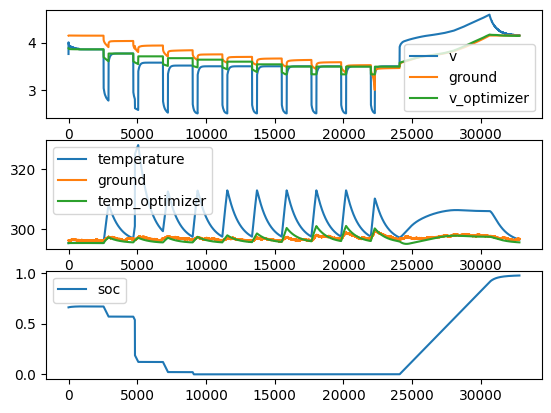

In [5]:
# plotting phase:
results = battery.build_results_table()
results = results['operations']

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

# Plot voltage data
ax1.plot(results['voltage'], label='v')
ax1.plot(df['voltage'][0:len(results['voltage'])], label='ground')
ax1.plot(v_optimizer[0:len(results['voltage'])], label='v_optimizer')
ax1.legend()

# Plot temperature data
ax2.plot(results['temperature'], label='temperature')
ax2.plot(df['temperature'][0:len(results['temperature'])], label='ground')
ax2.plot(temp_optimizer[0:len(results['temperature'])], label='temp_optimizer')
ax2.legend()

# Plot soc data
ax3.plot(results['soc'], label='soc')
#ax3.plot(df['soc'][0:len(results['temperature'])], label='ground')
ax3.legend()

# Plot loss history
#ax4.plot(loss_history, label='loss')
#ax4.legend()

plt.show()

In [6]:
print(loss_history)

[26312.7628505715]


In [7]:
print(theta)

{'r0': 0.008171321557172175, 'rc': 472.1811144855301, 'c': 9105208.782124389}
